# AutoML percentile correction on M5 (XGBoost)

This version selects percentiles by overall **MSE** (metric mode).


In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from datasetsforecast.m5 import M5
from mlforecast.auto import xgboost_space
import optuna

from utilsforecast.losses import rmse, mse, bias, mae

def eval_metrics(valid_df, preds_df, model_col: str):
    df = valid_df.merge(preds_df, on=["unique_id", "ds"], how="inner")
    return {
        "rows": len(df),
        "rmse": float(rmse(df, models=[model_col], id_col="unique_id", target_col="y")[model_col].mean()),
        "mse": float(mse(df, models=[model_col], id_col="unique_id", target_col="y")[model_col].mean()),
        "bias": float(bias(df, models=[model_col], id_col="unique_id", target_col="y")[model_col].mean()),
        "mae": float(mae(df, models=[model_col], id_col="unique_id", target_col="y")[model_col].mean()),
    }

def rmse_loss(df, train_df):  # train_df is unused here
    # df has columns: ['unique_id', 'ds', 'cutoff', 'y', 'model']
    return rmse(df, models=['model'], id_col='unique_id', target_col='y')['model'].mean()


/Users/janrathfelder/miniconda3/envs/mlforecast-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = 'data'
M5.download(data_dir)
Y_df, X_df, S_df = M5.load(directory=data_dir)
df = Y_df.copy()
df['ds'] = pd.to_datetime(df['ds'])

# Optional: subsample ids for faster experiments
MAX_IDS = 50
all_ids = df['unique_id'].unique()
if MAX_IDS is not None and len(all_ids) > MAX_IDS:
    rng = np.random.default_rng(0)
    keep_ids = rng.choice(all_ids, size=MAX_IDS, replace=False)
    df = df[df['unique_id'].isin(keep_ids)].copy()

h = 7
season_length = 7

# Percentile levels used for correction (customizable)
CORRECTION_LEVELS = list(range(5, 100, 5))

n_windows = 2
num_samples = 1  # increase for stronger tuning
optimize_kwargs = {'timeout': 300}


In [3]:
df.shape

(76545, 3)

In [4]:
def rolling_holdout_splits(df, h, n_test_sets, time_col='ds'):
    # assume all ids share same ds grid
    all_ds = pd.to_datetime(sorted(df[time_col].unique()))
    max_ds = all_ds[-1]
    step = pd.Timedelta(days=h)

    for k in range(n_test_sets):
        test_end = max_ds - k * step
        test_start = test_end - pd.Timedelta(days=h - 1)

        train = df[df[time_col] < test_start]
        test = df[(df[time_col] >= test_start) & (df[time_col] <= test_end)]

        yield k, train.reset_index(drop=True), test.reset_index(drop=True)


In [5]:
def tweedie_space(trial):
    params = xgboost_space(trial)
    params["objective"] = "reg:tweedie"
    params["tweedie_variance_power"] = 1.5
    params["eval_metric"] = "tweedie-nloglik@1.5"
    return params


In [6]:
from sklearn.preprocessing import FunctionTransformer
from mlforecast.target_transforms import LocalStandardScaler, GlobalSklearnTransformer

from mlforecast.lag_transforms import (RollingMean, ExponentiallyWeightedMean, ExpandingMax, ExpandingMin,
                                       RollingStd)

LAGS = [
    [1],
    [1, 2, 3],
    [1, 2, 3, 7],
    [1, 7, 14],
    [1, 7, 14, 28],
]

LAG_TRANSFORMS = [
    {1: [ExponentiallyWeightedMean(0.9),
         ExpandingMax(),
         ExpandingMin(),
         RollingStd(window_size=3, min_samples=1),
         RollingStd(window_size=8, min_samples=3),
         RollingMean(window_size=3, min_samples=1),
         RollingMean(window_size=8, min_samples=3)
         ]
     },
   # {
   #     1: [ExponentiallyWeightedMean(0.9)],
   #     7: [RollingMean(window_size=3, min_samples=1)],
   # },
]

DATE_FEATURES = ["year", "month", "week", "weekday"]  # standard calendar features

def my_init_config(trial):
    lags_idx = trial.suggest_int("lags_idx", 0, len(LAGS) - 1)
    ltfm_idx = trial.suggest_int("lag_tfms_idx", 0, len(LAG_TRANSFORMS) - 1)
    return {
        "target_transforms": None,   # no differencing
        "lags": LAGS[lags_idx],
        "lag_transforms": LAG_TRANSFORMS[ltfm_idx],
        "date_features": None,
    }


In [34]:
df.shape

(76545, 3)

In [74]:
def my_fit_config(trial):
    return {
        "dropna": False,
    }
    
# Percentile levels used for correction (customizable)
CORRECTION_LEVELS = list(range(1, 70, 2))

season_length = 7
h = 21
n_windows = 15
step_size = 7
num_samples = 10
    
n_test_sets = 12

rmse_base_test = []
mse_base_test = []
mae_base_test = []
bias_base_test = []

rmse_corr_test = []
mse_corr_test = []
mae_corr_test = []
bias_corr_test = []

cv_rmse_normal_cv = []
cv_bias_normal_cv = []

cv_rmse_corr_cv = []
cv_bias_corr_cv = []

rmse_base_only_corrected_test = []
mse_base_only_corrected_test = []
mae_base_only_corrected_test = []
bias_base_only_corrected_test = []

rmse_corr_only_corrected_test = []
mse_corr_only_corrected_test = []
mae_corr_only_corrected_test = []
bias_corr_only_corrected_test = []

delta_corr = []
delta_raw = []

share_correction = []
p_val_cv = []

for i, train_i, test_i in rolling_holdout_splits(df, h, n_test_sets):
    from mlforecast.auto import AutoMLForecast, AutoXGBoost, PredictionIntervals
    
    #auto_base = AutoMLForecast(
    #models={"xgb": AutoXGBoost(config=tweedie_space)},
    #freq="D",
    #init_config=my_init_config,
    #fit_config=my_fit_config,
    # reuse_cv_splits=True
    #)

    auto_corr = AutoMLForecast(
        models={"xgb": AutoXGBoost(config=tweedie_space)},
        freq="D",
        init_config=my_init_config,
        fit_config=my_fit_config,
        reuse_cv_splits=True
    )
    
    print(i, train_i.ds.min(), train_i.ds.max(), " | ", 
          test_i.ds.min(), test_i.ds.max())

    length_ids = train_i.groupby('unique_id').ds.nunique().reset_index()

    good_ids = length_ids[length_ids.ds > 55].unique_id.unique()

    train_i = train_i[train_i.unique_id.isin(good_ids)].copy()
    test_i = test_i[test_i.unique_id.isin(good_ids)].copy()
    
    #study_kwargs = {"sampler": optuna.samplers.TPESampler()} 
    # Train base model:
    #auto_base.fit(
    #df=train_i,
    #n_windows=n_windows,
    #h=h,
    #num_samples=num_samples,
    #optimize_kwargs=optimize_kwargs,
    #step_size=5,
    #loss=mse_loss,
    #study_kwargs={"sampler": optuna.samplers.TPESampler()}
    # prediction_intervals=PredictionIntervals(n_windows=n_windows, h=h),
    #)

    # preds_base = auto_base.predict(h=test_i.ds.nunique())
    # metrics_base = eval_metrics(test_i, preds_base, "xgb")
    
    # Train corrected model:
    auto_corr.fit(
    df=train_i,
    n_windows=n_windows,
    h=h,
    num_samples=num_samples,
    step_size=step_size,
    prediction_intervals=PredictionIntervals(n_windows=6, h=h),
    percentile_correction=True,
    percentile_correction_mode="metric",
    percentile_correction_metric="rmse", 
    percentile_correction_metric_kwargs=None,
    percentile_correction_levels=CORRECTION_LEVELS,
    compute_corrected_cv_metrics=True,
    loss=rmse_loss,
    study_kwargs={"sampler": optuna.samplers.TPESampler()}
    )
    
    preds_corr = auto_corr.predict(h=test_i.ds.nunique())
    
    name = "xgb"
    corr = auto_corr.percentile_correction_[name]
    corr_ids = list(corr["id_to_col"].keys())
    raw_preds = auto_corr.models_[name].predict(
        h=test_i.ds.nunique(),
        level=corr["levels"],  # make sure percentile cols exist
    )
    
    metrics_corr = eval_metrics(test_i, preds_corr, "xgb")
    metrics_base = eval_metrics(test_i, raw_preds, "xgb")
    
    metrics_corr_only_corrected = eval_metrics(test_i[test_i.unique_id.isin(corr_ids)], 
                                                 preds_corr[preds_corr.unique_id.isin(corr_ids)], "xgb")
    metrics_base_only_corrected = eval_metrics(test_i[test_i.unique_id.isin(corr_ids)], 
                                                 raw_preds[raw_preds.unique_id.isin(corr_ids)], "xgb")
    
    rmse_base = metrics_base['rmse']
    mse_base = metrics_base['mse']
    mae_base = metrics_base['mae']
    bias_base = metrics_base['bias']
    
    rmse_corr = metrics_corr['rmse']
    mse_corr = metrics_corr['mse']
    mae_corr = metrics_corr['mae']
    bias_corr = metrics_corr['bias']
    
    rmse_base_only_corrected = metrics_base_only_corrected['rmse']
    mse_base_only_corrected = metrics_base_only_corrected['mse']
    mae_base_only_corrected = metrics_base_only_corrected['mae']
    bias_base_only_corrected = metrics_base_only_corrected['bias']
    
    rmse_corr = metrics_corr['rmse']
    mse_corr = metrics_corr['mse']
    mae_corr = metrics_corr['mae']
    bias_corr = metrics_corr['bias']
    
    rmse_corr_only_corrected = metrics_corr_only_corrected ['rmse']
    mse_corr_only_corrected = metrics_corr_only_corrected ['mse']
    mae_corr_only_corrected = metrics_corr_only_corrected ['mae']
    bias_corr_only_corrected = metrics_corr_only_corrected ['bias']
    
    cv_rmse_normal = auto_corr.cv_metrics_["xgb"]['rmse']
    cv_bias_normal = auto_corr.cv_metrics_["xgb"]['bias']
    
    cv_rmse_corr = auto_corr.cv_metrics_corrected_["xgb"]['rmse']
    cv_bias_corr = auto_corr.cv_metrics_corrected_["xgb"]['bias']
    
    delta_corr_temp = (preds_corr[preds_corr.unique_id.isin(corr_ids)].xgb.sum() / 
                  test_i[test_i.unique_id.isin(corr_ids)].y.sum() - 1)
    delta_raw_temp = (raw_preds[raw_preds.unique_id.isin(corr_ids)].xgb.sum() / 
                 test_i[test_i.unique_id.isin(corr_ids)].y.sum() - 1 )
    
    #############
    # save outputs
    rmse_base_test.append(rmse_base)
    mse_base_test.append(mse_base)
    mae_base_test.append(mae_base)
    bias_base_test.append(bias_base)
    
    rmse_corr_test.append(rmse_corr)
    mse_corr_test.append(mse_corr)
    mae_corr_test.append(mae_corr)
    bias_corr_test.append(bias_corr)
    
    rmse_base_only_corrected_test.append(rmse_base_only_corrected)
    mse_base_only_corrected_test.append(mse_base_only_corrected)
    mae_base_only_corrected_test.append(mae_base_only_corrected)
    bias_base_only_corrected_test.append(bias_base_only_corrected)
    
    rmse_corr_only_corrected_test.append(rmse_corr_only_corrected)
    mse_corr_only_corrected_test.append(mse_corr_only_corrected)
    mae_corr_only_corrected_test.append(mae_corr_only_corrected)
    bias_corr_only_corrected_test.append(bias_corr_only_corrected)
    
    cv_rmse_normal_cv.append(cv_rmse_normal)
    cv_bias_normal_cv.append(cv_bias_normal)
    
    cv_rmse_corr_cv.append(cv_rmse_corr)
    cv_bias_corr_cv.append(cv_bias_corr)
    
    delta_corr.append(delta_corr_temp)
    delta_raw.append(delta_raw_temp)
    ###############
    # Get base and corrected forecast from correction model:
    

    # raw predictions WITH the needed percentile columns
    #raw_preds = auto_corr.models_[name].predict(
    #    h=test_i.ds.nunique(),
    #    level=corr["levels"],  # make sure percentile cols exist
    #)

    # corrected predictions (auto_corr.predict applies correction)
    preds_optimal = auto_corr.predict(h=test_i.ds.nunique())
    ###############
    preds_all = raw_preds.merge(preds_optimal, on=['ds', 'unique_id'])
    
    corr_ids_str = set(map(str, corr_ids))
    preds_all = preds_all[preds_all.unique_id.astype(str).isin(corr_ids_str)]
    
    preds_all = preds_all.merge(test_i, on=['ds', 'unique_id'])

    preds_all['res_base'] = abs(preds_all.xgb_x - preds_all.y)
    preds_all['res_best'] = abs(preds_all.xgb_y - preds_all.y)

    preds_all['flag'] = np.where(preds_all.res_best < preds_all.res_base, 1, 0)
    share_correction.append(preds_all['flag'].mean())
    #############
    # Run t-test:
    t_stat, p_val = stats.ttest_ind(preds_all.xgb_x, 
                                preds_all.xgb_y, 
                                equal_var=True)  
    p_val_cv.append(p_val)

/var/folders/nk/kvcs64mn4nbfqfw1ff_czjn80000gn/T/ipykernel_22678/611657975.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_ids = train_i.groupby('unique_id').ds.nunique().reset_index()
[I 2026-02-23 18:22:40,248] A new study created in memory with name: no-name-4a86fb78-0122-4665-a6be-c496ecae19ca


0 2011-01-29 00:00:00 2016-05-29 00:00:00  |  2016-05-30 00:00:00 2016-06-19 00:00:00


[I 2026-02-23 18:22:41,667] Trial 0 finished with value: 1.2419867515563965 and parameters: {'n_estimators': 585, 'max_depth': 1, 'learning_rate': 0.042414076294338236, 'subsample': 0.9121396588155565, 'colsample_bytree': 0.7527257032405803, 'reg_lambda': 3.470213363921503e-05, 'reg_alpha': 4.550561041847825e-08, 'min_child_weight': 4, 'lags_idx': 0, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.2419867515563965.
[I 2026-02-23 18:22:44,486] Trial 1 finished with value: 1.2494425773620605 and parameters: {'n_estimators': 923, 'max_depth': 3, 'learning_rate': 0.00973344700580069, 'subsample': 0.9201168037227192, 'colsample_bytree': 0.9879649492402524, 'reg_lambda': 1.4770276966180857e-07, 'reg_alpha': 7.454893883079279e-07, 'min_child_weight': 6, 'lags_idx': 1, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.2419867515563965.
[I 2026-02-23 18:22:47,491] Trial 2 finished with value: 1.2171930074691772 and parameters: {'n_estimators': 873, 'max_depth': 6, 'learning_rate': 0.006514301

1 2011-01-29 00:00:00 2016-05-08 00:00:00  |  2016-05-09 00:00:00 2016-05-29 00:00:00


[I 2026-02-23 18:25:27,624] Trial 0 finished with value: 1.4963361024856567 and parameters: {'n_estimators': 55, 'max_depth': 3, 'learning_rate': 0.009730009556236988, 'subsample': 0.10637352365822098, 'colsample_bytree': 0.8279127060639531, 'reg_lambda': 0.22218852370167266, 'reg_alpha': 3.7785995130986456e-07, 'min_child_weight': 7, 'lags_idx': 0, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.4963361024856567.
[I 2026-02-23 18:25:33,602] Trial 1 finished with value: 1.219086766242981 and parameters: {'n_estimators': 930, 'max_depth': 10, 'learning_rate': 0.00703106592783712, 'subsample': 0.5122991612776274, 'colsample_bytree': 0.9419760444112592, 'reg_lambda': 6.347815430691177e-08, 'reg_alpha': 9.26523373050855e-08, 'min_child_weight': 7, 'lags_idx': 3, 'lag_tfms_idx': 0}. Best is trial 1 with value: 1.219086766242981.
[I 2026-02-23 18:25:37,028] Trial 2 finished with value: 1.4690499305725098 and parameters: {'n_estimators': 664, 'max_depth': 8, 'learning_rate': 0.0012505069591

2 2011-01-29 00:00:00 2016-04-17 00:00:00  |  2016-04-18 00:00:00 2016-05-08 00:00:00


[I 2026-02-23 18:30:41,330] Trial 0 finished with value: 1.4227612018585205 and parameters: {'n_estimators': 566, 'max_depth': 5, 'learning_rate': 0.0025663882758379794, 'subsample': 0.3178169510825383, 'colsample_bytree': 0.10038247357006837, 'reg_lambda': 3.835429196568932e-08, 'reg_alpha': 0.01279087537605189, 'min_child_weight': 9, 'lags_idx': 1, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.4227612018585205.
[I 2026-02-23 18:30:42,913] Trial 1 finished with value: 1.2343019247055054 and parameters: {'n_estimators': 895, 'max_depth': 1, 'learning_rate': 0.05163603466203124, 'subsample': 0.9028668036434404, 'colsample_bytree': 0.4889622195633575, 'reg_lambda': 0.0006614804879632828, 'reg_alpha': 0.023492211223179547, 'min_child_weight': 9, 'lags_idx': 2, 'lag_tfms_idx': 0}. Best is trial 1 with value: 1.2343019247055054.
[I 2026-02-23 18:30:43,804] Trial 2 finished with value: 1.3947796821594238 and parameters: {'n_estimators': 160, 'max_depth': 4, 'learning_rate': 0.00831998127

3 2011-01-29 00:00:00 2016-03-27 00:00:00  |  2016-03-28 00:00:00 2016-04-17 00:00:00


[I 2026-02-23 18:32:13,503] Trial 0 finished with value: 1.2301218509674072 and parameters: {'n_estimators': 616, 'max_depth': 7, 'learning_rate': 0.019712935766589324, 'subsample': 0.25950805736477206, 'colsample_bytree': 0.7005492321836131, 'reg_lambda': 1.2115914113872434e-08, 'reg_alpha': 0.011807266129258746, 'min_child_weight': 10, 'lags_idx': 4, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.2301218509674072.
[I 2026-02-23 18:32:14,681] Trial 1 finished with value: 1.2782533168792725 and parameters: {'n_estimators': 260, 'max_depth': 6, 'learning_rate': 0.15663019653293733, 'subsample': 0.629300950460334, 'colsample_bytree': 0.8184422109651577, 'reg_lambda': 7.464493804506647e-07, 'reg_alpha': 1.0094437113833436e-08, 'min_child_weight': 6, 'lags_idx': 1, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.2301218509674072.
[I 2026-02-23 18:32:16,458] Trial 2 finished with value: 1.2548884153366089 and parameters: {'n_estimators': 642, 'max_depth': 5, 'learning_rate': 0.01807823

4 2011-01-29 00:00:00 2016-03-06 00:00:00  |  2016-03-07 00:00:00 2016-03-27 00:00:00


[I 2026-02-23 18:34:24,903] Trial 0 finished with value: 1.2657684087753296 and parameters: {'n_estimators': 464, 'max_depth': 5, 'learning_rate': 0.05919592430999255, 'subsample': 0.566629281993738, 'colsample_bytree': 0.356409916077209, 'reg_lambda': 5.388039024855554e-08, 'reg_alpha': 6.927024447062494e-05, 'min_child_weight': 5, 'lags_idx': 1, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.2657684087753296.
[I 2026-02-23 18:34:26,339] Trial 1 finished with value: 1.265190601348877 and parameters: {'n_estimators': 354, 'max_depth': 7, 'learning_rate': 0.051270154489767024, 'subsample': 0.700972992185077, 'colsample_bytree': 0.24349810823334803, 'reg_lambda': 0.00807847815412144, 'reg_alpha': 1.0597532036813623e-07, 'min_child_weight': 7, 'lags_idx': 1, 'lag_tfms_idx': 0}. Best is trial 1 with value: 1.265190601348877.
[I 2026-02-23 18:34:28,516] Trial 2 finished with value: 1.2710362672805786 and parameters: {'n_estimators': 547, 'max_depth': 7, 'learning_rate': 0.004599867210273

5 2011-01-29 00:00:00 2016-02-14 00:00:00  |  2016-02-15 00:00:00 2016-03-06 00:00:00


[I 2026-02-23 18:50:21,536] Trial 0 finished with value: 1.261381983757019 and parameters: {'n_estimators': 959, 'max_depth': 9, 'learning_rate': 0.0040508432365969375, 'subsample': 0.21372813979160735, 'colsample_bytree': 0.21439469840811137, 'reg_lambda': 0.0076271753163620415, 'reg_alpha': 0.002164360980019198, 'min_child_weight': 2, 'lags_idx': 2, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.261381983757019.
[I 2026-02-23 18:50:24,300] Trial 1 finished with value: 1.459459900856018 and parameters: {'n_estimators': 915, 'max_depth': 6, 'learning_rate': 0.08900110037332412, 'subsample': 0.17615485237852757, 'colsample_bytree': 0.7783797683537885, 'reg_lambda': 0.030810006548689838, 'reg_alpha': 3.472723350136441e-07, 'min_child_weight': 2, 'lags_idx': 2, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.261381983757019.
[I 2026-02-23 18:50:26,019] Trial 2 finished with value: 1.2366307973861694 and parameters: {'n_estimators': 559, 'max_depth': 5, 'learning_rate': 0.023979157726

6 2011-01-29 00:00:00 2016-01-24 00:00:00  |  2016-01-25 00:00:00 2016-02-14 00:00:00


[I 2026-02-23 18:51:53,600] Trial 0 finished with value: 1.4152566194534302 and parameters: {'n_estimators': 821, 'max_depth': 10, 'learning_rate': 0.002204562362805582, 'subsample': 0.6606095691228866, 'colsample_bytree': 0.16727207901173813, 'reg_lambda': 1.3474362880038494e-07, 'reg_alpha': 1.6236554534754247e-06, 'min_child_weight': 10, 'lags_idx': 1, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.4152566194534302.
[I 2026-02-23 18:51:55,375] Trial 1 finished with value: 1.3841016292572021 and parameters: {'n_estimators': 672, 'max_depth': 5, 'learning_rate': 0.18838301074817174, 'subsample': 0.916896111799977, 'colsample_bytree': 0.9786106704421494, 'reg_lambda': 0.21017167335268577, 'reg_alpha': 6.69962204529204e-06, 'min_child_weight': 5, 'lags_idx': 0, 'lag_tfms_idx': 0}. Best is trial 1 with value: 1.3841016292572021.
[I 2026-02-23 18:51:57,606] Trial 2 finished with value: 1.2605444192886353 and parameters: {'n_estimators': 913, 'max_depth': 4, 'learning_rate': 0.003008445

7 2011-01-29 00:00:00 2016-01-03 00:00:00  |  2016-01-04 00:00:00 2016-01-24 00:00:00


[I 2026-02-23 18:53:42,353] Trial 0 finished with value: 1.3921715021133423 and parameters: {'n_estimators': 327, 'max_depth': 10, 'learning_rate': 0.003774374272074146, 'subsample': 0.5467876082098214, 'colsample_bytree': 0.9959406786811328, 'reg_lambda': 3.8415784199204565e-07, 'reg_alpha': 0.19979333596720258, 'min_child_weight': 4, 'lags_idx': 4, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.3921715021133423.
[I 2026-02-23 18:53:44,726] Trial 1 finished with value: 1.2801227569580078 and parameters: {'n_estimators': 581, 'max_depth': 8, 'learning_rate': 0.023788014625884504, 'subsample': 0.6401258949828195, 'colsample_bytree': 0.8696380760773711, 'reg_lambda': 0.0008286606326315169, 'reg_alpha': 0.13688312723008067, 'min_child_weight': 10, 'lags_idx': 2, 'lag_tfms_idx': 0}. Best is trial 1 with value: 1.2801227569580078.
[I 2026-02-23 18:53:47,285] Trial 2 finished with value: 1.2843077182769775 and parameters: {'n_estimators': 752, 'max_depth': 8, 'learning_rate': 0.0284932955

8 2011-01-29 00:00:00 2015-12-13 00:00:00  |  2015-12-14 00:00:00 2016-01-03 00:00:00


[I 2026-02-23 18:56:34,892] Trial 0 finished with value: 1.2842577695846558 and parameters: {'n_estimators': 619, 'max_depth': 6, 'learning_rate': 0.04113973001582724, 'subsample': 0.6204730242820878, 'colsample_bytree': 0.6050822897053132, 'reg_lambda': 0.0006667815350804403, 'reg_alpha': 0.10999900245178247, 'min_child_weight': 3, 'lags_idx': 1, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.2842577695846558.
[I 2026-02-23 18:56:35,680] Trial 1 finished with value: 1.6212717294692993 and parameters: {'n_estimators': 92, 'max_depth': 10, 'learning_rate': 0.005585171752033711, 'subsample': 0.534786416211176, 'colsample_bytree': 0.13288672390899486, 'reg_lambda': 0.163404172700637, 'reg_alpha': 0.08819457105894374, 'min_child_weight': 3, 'lags_idx': 3, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.2842577695846558.
[I 2026-02-23 18:56:37,479] Trial 2 finished with value: 1.3227728605270386 and parameters: {'n_estimators': 568, 'max_depth': 7, 'learning_rate': 0.04777565844545113,

9 2011-01-29 00:00:00 2015-11-22 00:00:00  |  2015-11-23 00:00:00 2015-12-13 00:00:00


[I 2026-02-23 18:58:15,659] Trial 0 finished with value: 1.6701316833496094 and parameters: {'n_estimators': 46, 'max_depth': 3, 'learning_rate': 0.00559889469907851, 'subsample': 0.3937732755469233, 'colsample_bytree': 0.4859071648983025, 'reg_lambda': 3.686503269120186e-07, 'reg_alpha': 2.1851583275454317e-07, 'min_child_weight': 4, 'lags_idx': 3, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.6701316833496094.
[I 2026-02-23 18:58:16,363] Trial 1 finished with value: 1.6537973880767822 and parameters: {'n_estimators': 135, 'max_depth': 2, 'learning_rate': 0.002346000028335007, 'subsample': 0.4518960529089299, 'colsample_bytree': 0.5701990236781892, 'reg_lambda': 0.00031930032687215733, 'reg_alpha': 0.002621476532206443, 'min_child_weight': 10, 'lags_idx': 0, 'lag_tfms_idx': 0}. Best is trial 1 with value: 1.6537973880767822.
[I 2026-02-23 18:58:17,906] Trial 2 finished with value: 1.485163927078247 and parameters: {'n_estimators': 496, 'max_depth': 5, 'learning_rate': 0.0020361086

10 2011-01-29 00:00:00 2015-11-01 00:00:00  |  2015-11-02 00:00:00 2015-11-22 00:00:00


[I 2026-02-23 18:59:38,167] Trial 0 finished with value: 1.2779659032821655 and parameters: {'n_estimators': 951, 'max_depth': 10, 'learning_rate': 0.004877200126799425, 'subsample': 0.16455951194561458, 'colsample_bytree': 0.6723783288793608, 'reg_lambda': 0.2639472470351779, 'reg_alpha': 0.5866663441094508, 'min_child_weight': 9, 'lags_idx': 4, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.2779659032821655.
[I 2026-02-23 18:59:39,282] Trial 1 finished with value: 1.2906419038772583 and parameters: {'n_estimators': 450, 'max_depth': 2, 'learning_rate': 0.03189337680550003, 'subsample': 0.53907899407424, 'colsample_bytree': 0.5716366380365261, 'reg_lambda': 0.0021396886101977997, 'reg_alpha': 0.0016810291264683164, 'min_child_weight': 9, 'lags_idx': 2, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.2779659032821655.
[I 2026-02-23 18:59:39,998] Trial 2 finished with value: 1.6586437225341797 and parameters: {'n_estimators': 130, 'max_depth': 3, 'learning_rate': 0.0030440019868149

11 2011-01-29 00:00:00 2015-10-11 00:00:00  |  2015-10-12 00:00:00 2015-11-01 00:00:00


[I 2026-02-23 19:01:31,176] Trial 0 finished with value: 1.304125189781189 and parameters: {'n_estimators': 893, 'max_depth': 6, 'learning_rate': 0.04873867742674716, 'subsample': 0.8611834348365414, 'colsample_bytree': 0.8112666672161404, 'reg_lambda': 0.11929087772387785, 'reg_alpha': 3.4267767708799326e-07, 'min_child_weight': 8, 'lags_idx': 2, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.304125189781189.
[I 2026-02-23 19:01:32,587] Trial 1 finished with value: 1.2981884479522705 and parameters: {'n_estimators': 876, 'max_depth': 1, 'learning_rate': 0.19091098605930829, 'subsample': 0.9359911642926834, 'colsample_bytree': 0.28802837003282267, 'reg_lambda': 0.02235039634996845, 'reg_alpha': 1.698669454904682e-06, 'min_child_weight': 5, 'lags_idx': 1, 'lag_tfms_idx': 0}. Best is trial 1 with value: 1.2981884479522705.
[I 2026-02-23 19:01:35,971] Trial 2 finished with value: 1.3913894891738892 and parameters: {'n_estimators': 969, 'max_depth': 7, 'learning_rate': 0.001469635227953

In [77]:
np.mean(delta_corr)

np.float32(0.034472153)

In [78]:
np.mean(delta_raw)

np.float32(-0.035743862)

(array([2., 2., 1., 2., 0., 0., 2., 1., 0., 2.]),
 array([-0.21340555, -0.17256325, -0.13172098, -0.09087869, -0.0500364 ,
        -0.00919411,  0.03164817,  0.07249045,  0.11333275,  0.15417504,
         0.19501734]),
 <BarContainer object of 10 artists>)

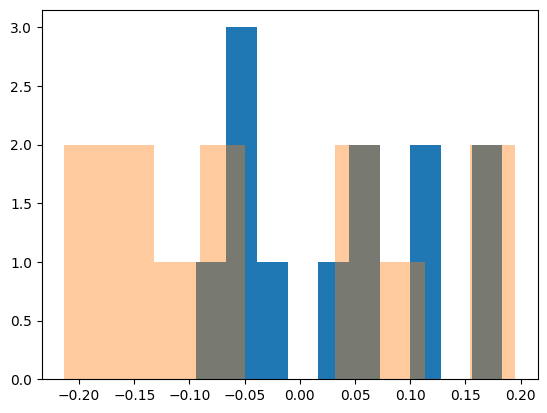

In [75]:
plt.hist(delta_corr)
plt.hist(delta_raw, alpha=.4)

In [96]:
len(mae_corr_only_corrected_test)

12

In [ ]:
# mae improvement

np.mean(mae_corr_only_corrected_test) / np.mean(mae_base_only_corrected_test) - 1

np.float64(-0.011604532729328376)

In [ ]:
# rmse improvement

np.mean(rmse_corr_only_corrected_test) / np.mean(rmse_base_only_corrected_test) - 1

np.float64(-0.009112683273174604)

In [ ]:
# share of rmse for corr better than for base

a = np.array(rmse_corr_only_corrected_test)
b = np.array(rmse_base_only_corrected_test)

mask = a < b
count = mask.sum()
idxs = np.where(mask)[0]
len(idxs) / len(a)

0.6666666666666666

In [ ]:
# share of bias for corr better than for base

a = np.array(np.abs(bias_corr_only_corrected_test))
b = np.array(np.abs(bias_base_only_corrected_test))

mask = a < b
count = mask.sum()
idxs = np.where(mask)[0]
len(idxs) / len(a)

0.8333333333333334

In [95]:
share_correction

[np.float64(0.5647619047619048),
 np.float64(0.6314285714285715),
 np.float64(0.6),
 np.float64(0.621904761904762),
 np.float64(0.6057142857142858),
 np.float64(0.5914285714285714),
 np.float64(0.518095238095238),
 np.float64(0.559047619047619),
 np.float64(0.5742857142857143),
 np.float64(0.49047619047619045),
 np.float64(0.5438095238095239),
 np.float64(0.5847619047619048)]

In [97]:
np.mean(share_correction)

np.float64(0.5738095238095238)

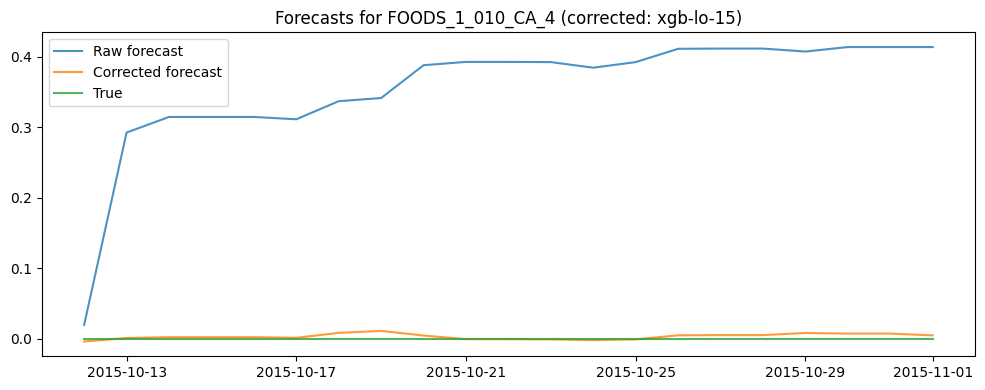

(np.float32(7.4695735), np.float32(0.06753294), np.float32(0.0))


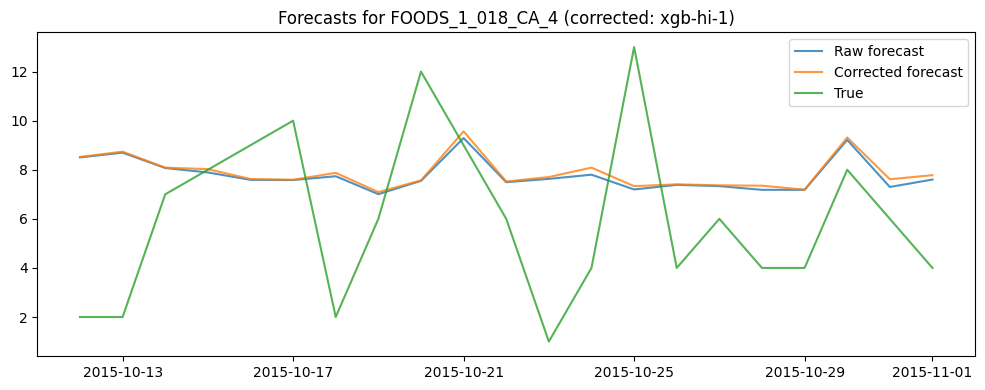

(np.float32(163.23572), np.float32(165.3491), np.float32(127.0))


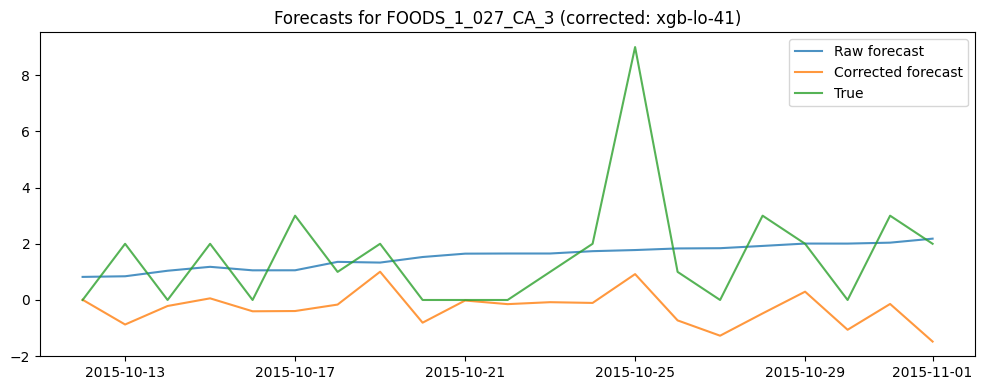

(np.float32(32.523994), np.float32(-6.0664372), np.float32(33.0))


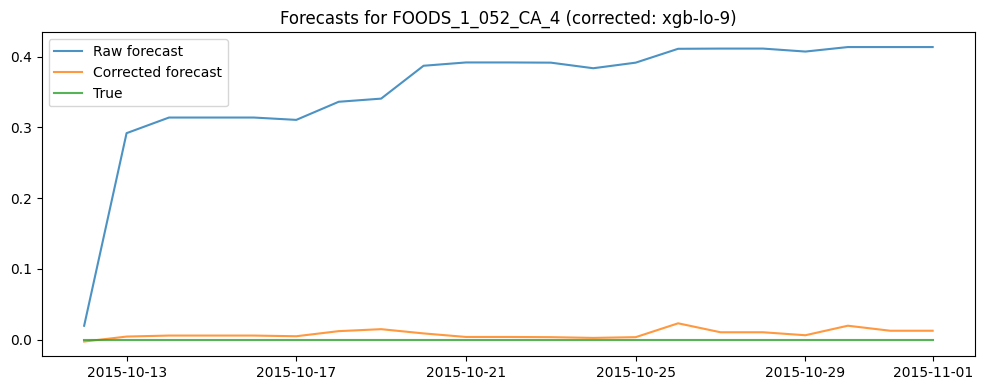

(np.float32(7.461002), np.float32(0.16806455), np.float32(0.0))


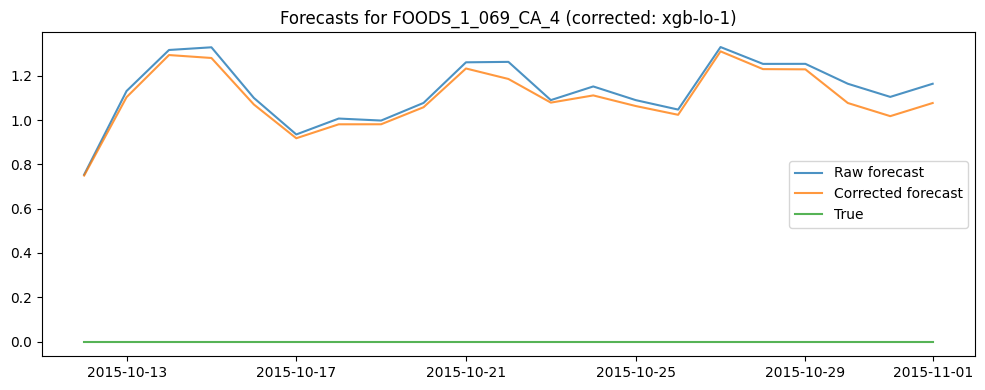

(np.float32(23.825056), np.float32(23.077097), np.float32(0.0))


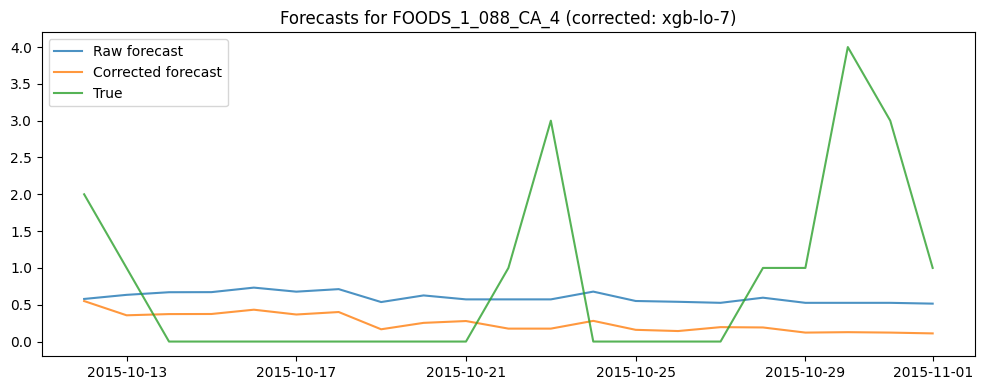

(np.float32(12.541698), np.float32(5.357504), np.float32(17.0))


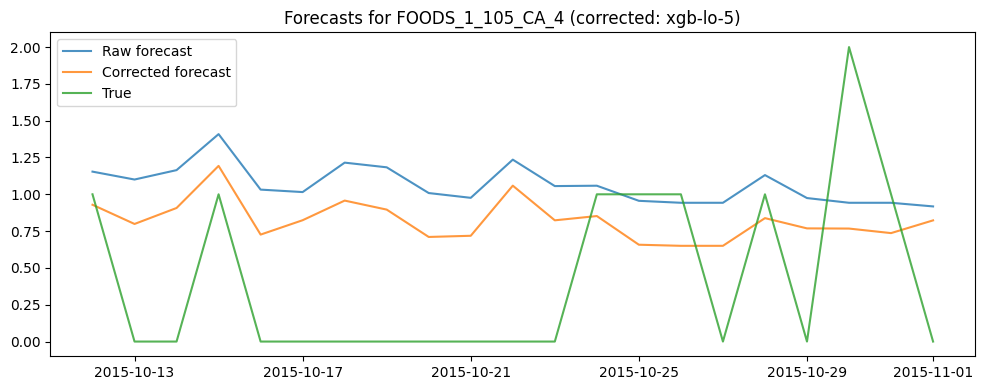

(np.float32(22.35532), np.float32(17.286367), np.float32(9.0))


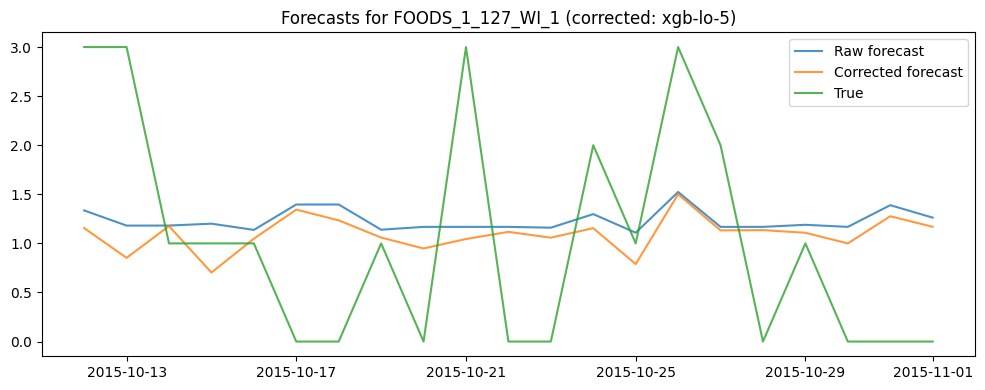

(np.float32(25.909239), np.float32(23.009119), np.float32(22.0))


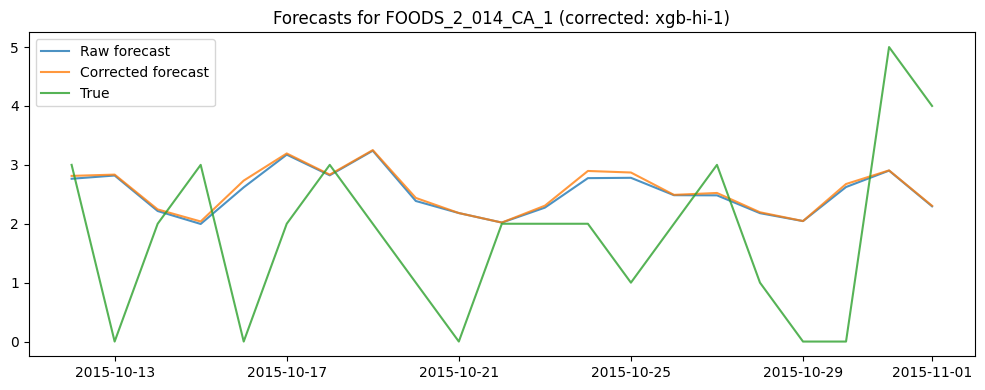

(np.float32(53.078926), np.float32(53.794178), np.float32(38.0))


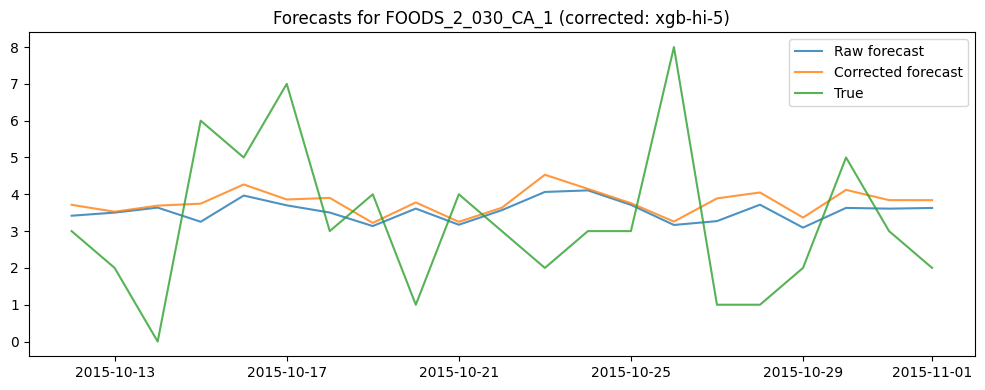

(np.float32(74.48225), np.float32(79.404785), np.float32(68.0))


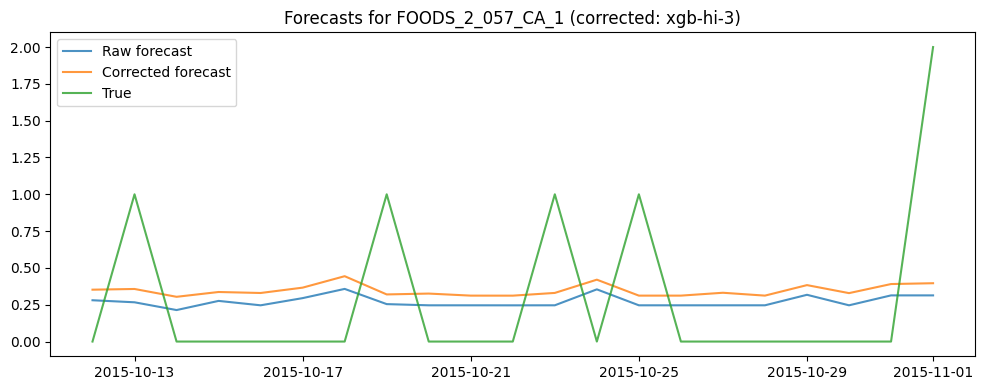

(np.float32(5.704373), np.float32(7.2757454), np.float32(6.0))


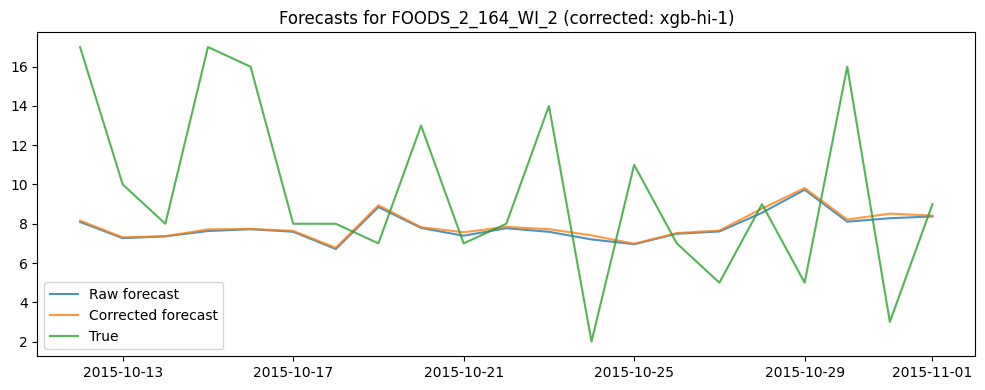

(np.float32(164.0767), np.float32(165.89763), np.float32(200.0))


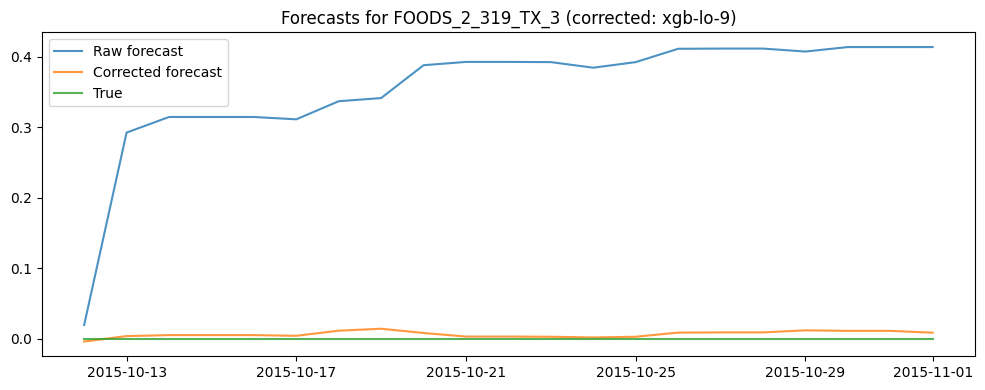

(np.float32(7.4695735), np.float32(0.14155334), np.float32(0.0))


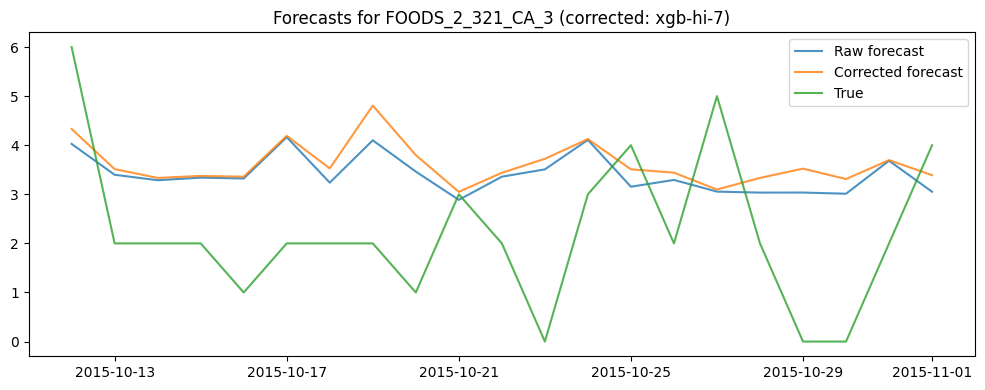

(np.float32(71.52153), np.float32(75.87408), np.float32(47.0))


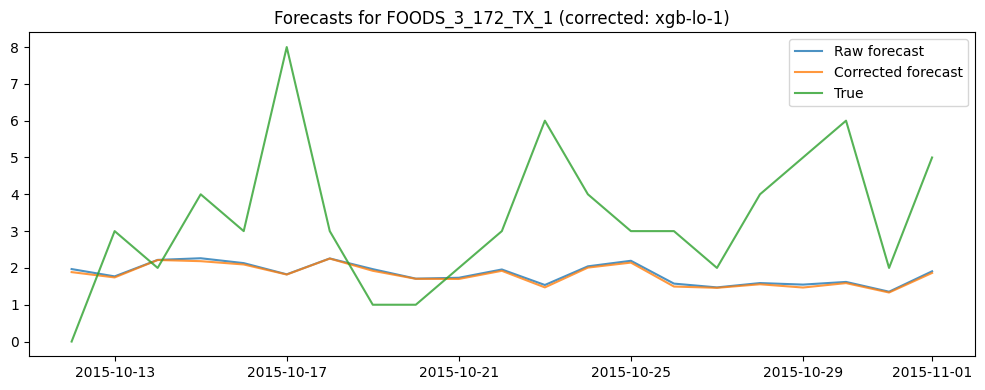

(np.float32(38.63887), np.float32(37.829647), np.float32(70.0))


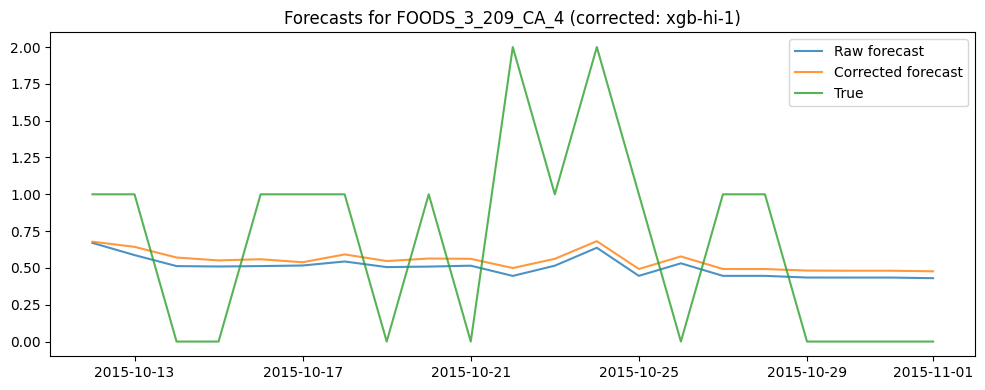

(np.float32(10.58371), np.float32(11.524735), np.float32(14.0))


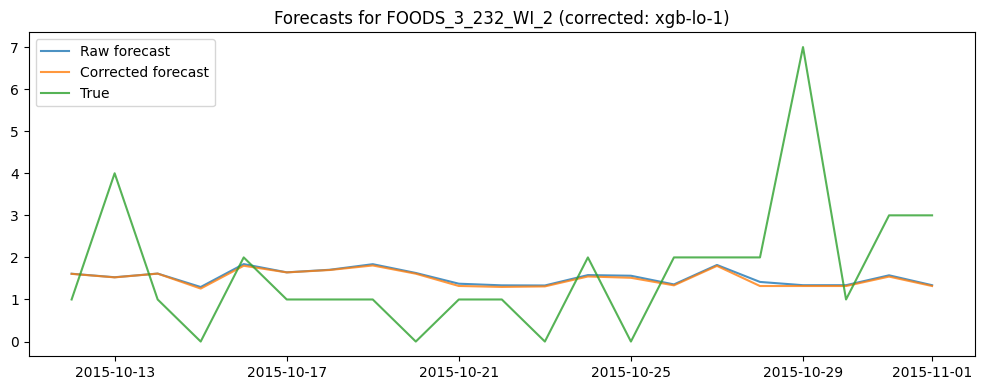

(np.float32(32.091316), np.float32(31.526499), np.float32(35.0))


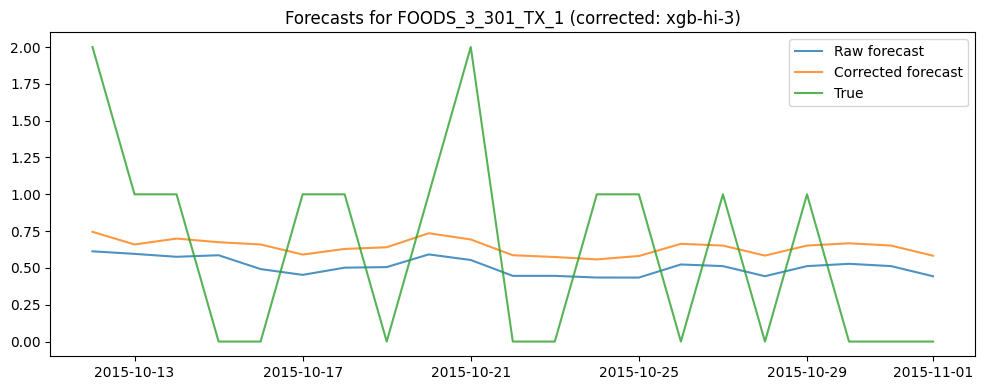

(np.float32(10.705469), np.float32(13.479752), np.float32(13.0))


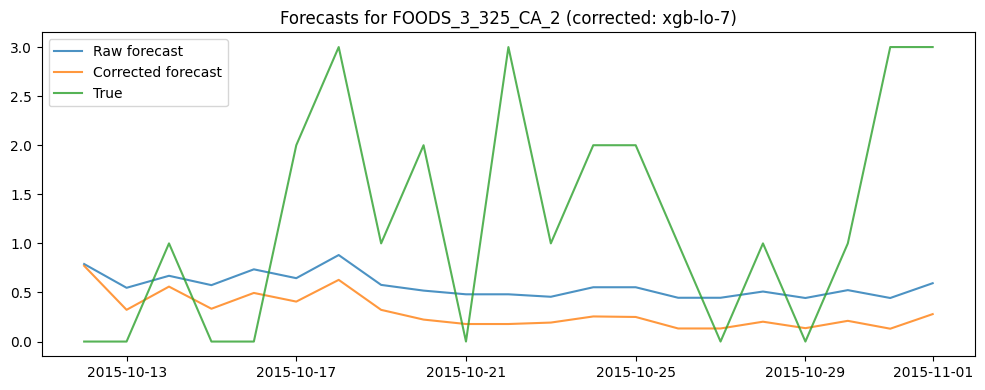

(np.float32(11.873471), np.float32(6.349657), np.float32(26.0))


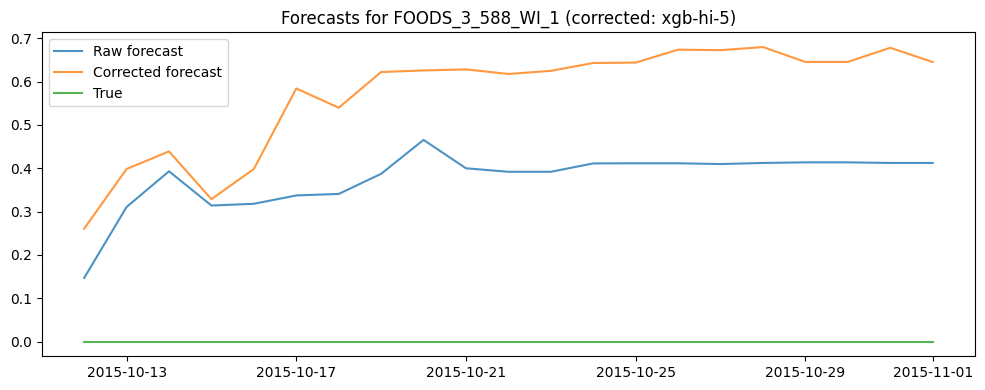

(np.float32(7.9044), np.float32(11.993921), np.float32(0.0))


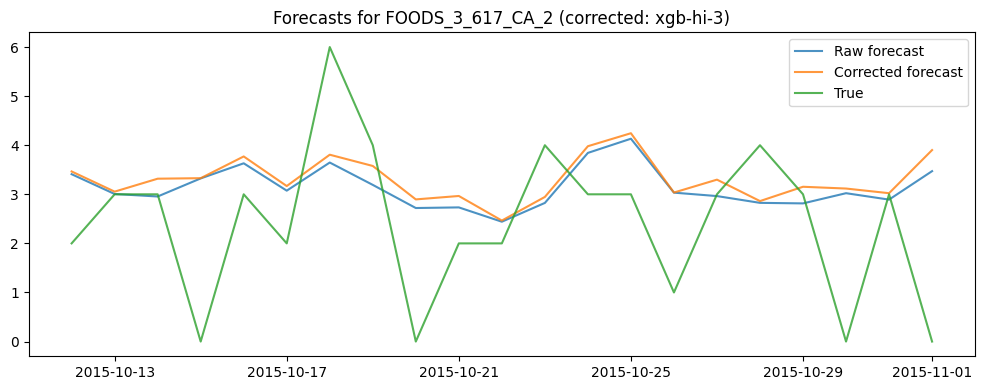

(np.float32(65.961), np.float32(69.37948), np.float32(51.0))


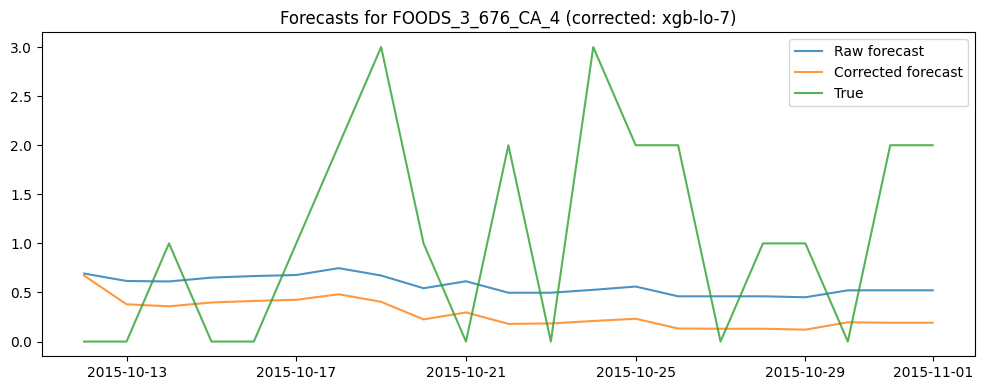

(np.float32(11.977644), np.float32(5.9574447), np.float32(23.0))


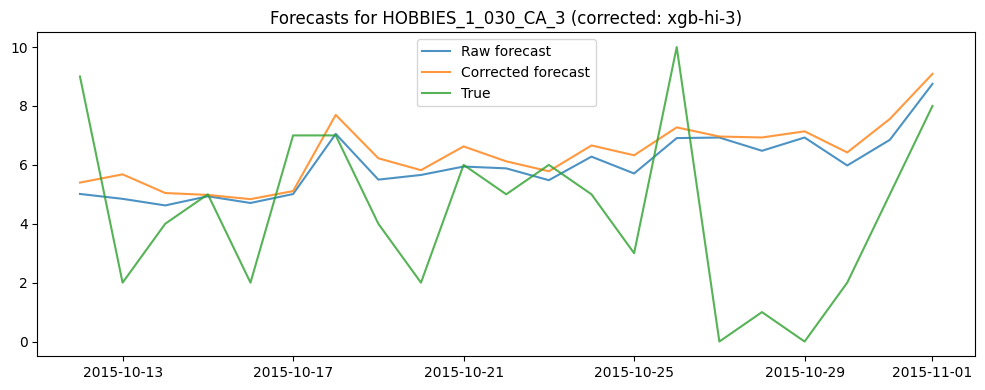

(np.float32(125.44497), np.float32(133.66725), np.float32(93.0))


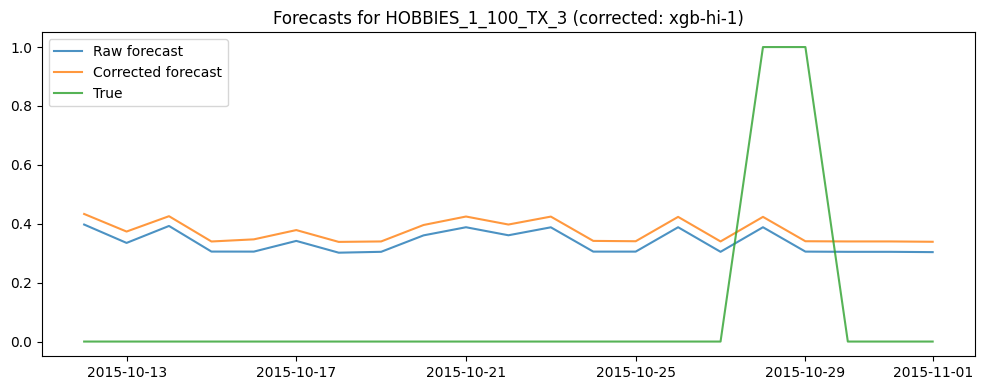

(np.float32(7.0918965), np.float32(7.8466353), np.float32(2.0))


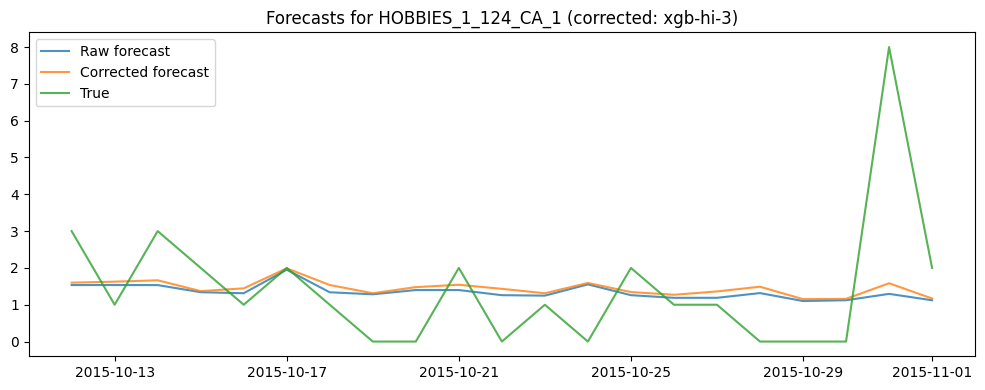

(np.float32(28.282753), np.float32(30.432985), np.float32(30.0))


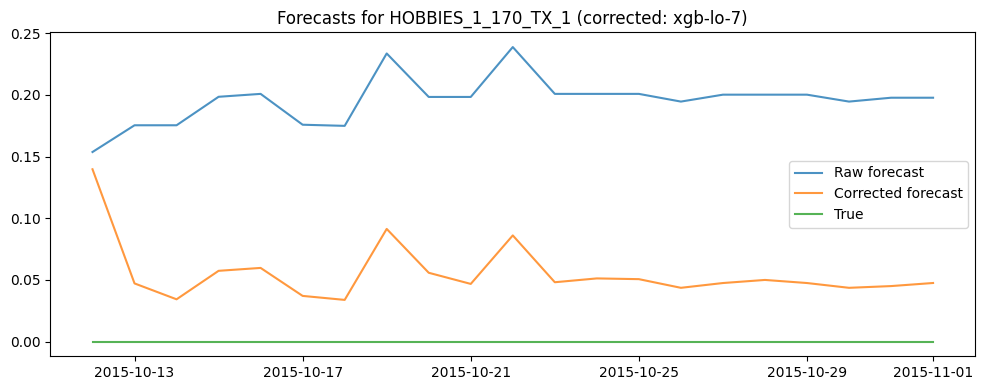

(np.float32(4.110166), np.float32(1.1629525), np.float32(0.0))


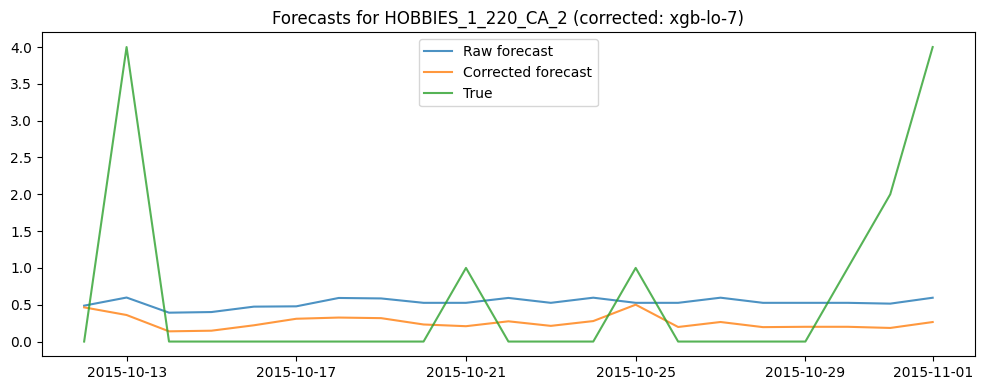

(np.float32(11.11035), np.float32(5.503079), np.float32(13.0))


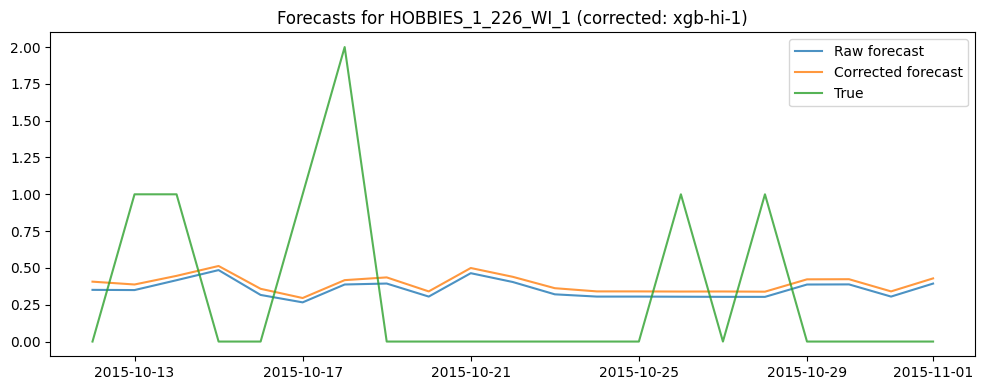

(np.float32(7.458671), np.float32(8.217304), np.float32(7.0))


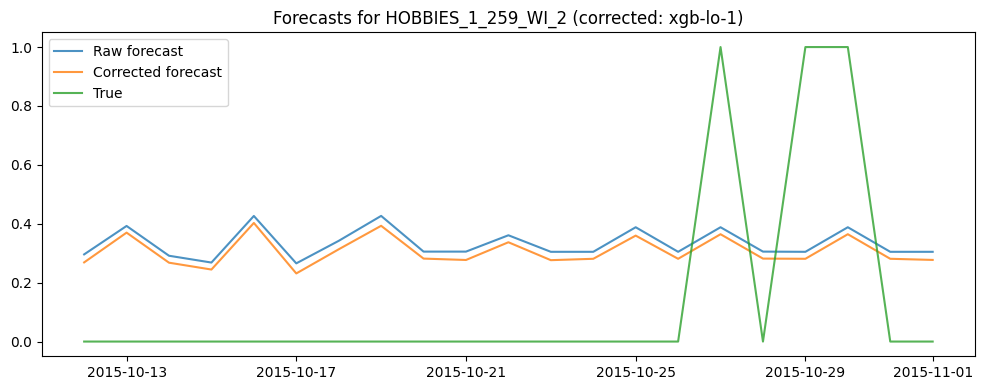

(np.float32(6.978762), np.float32(6.4352446), np.float32(3.0))


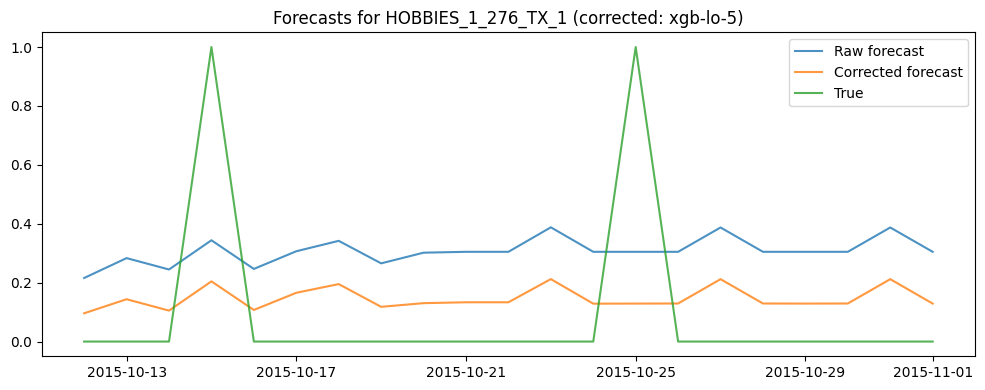

(np.float32(6.4553156), np.float32(3.071106), np.float32(2.0))


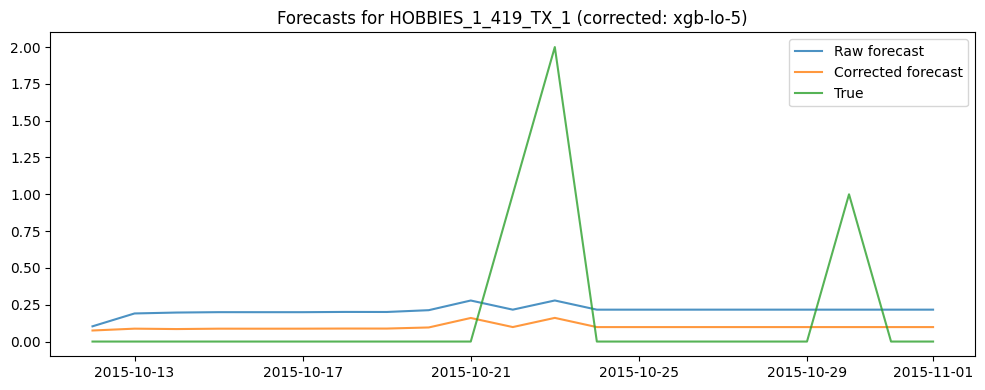

(np.float32(4.4287224), np.float32(2.0853107), np.float32(4.0))


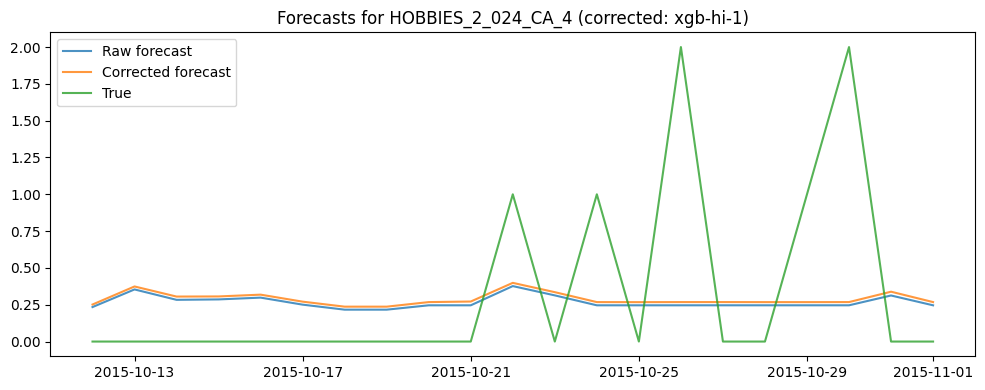

(np.float32(5.60459), np.float32(6.0564437), np.float32(7.0))


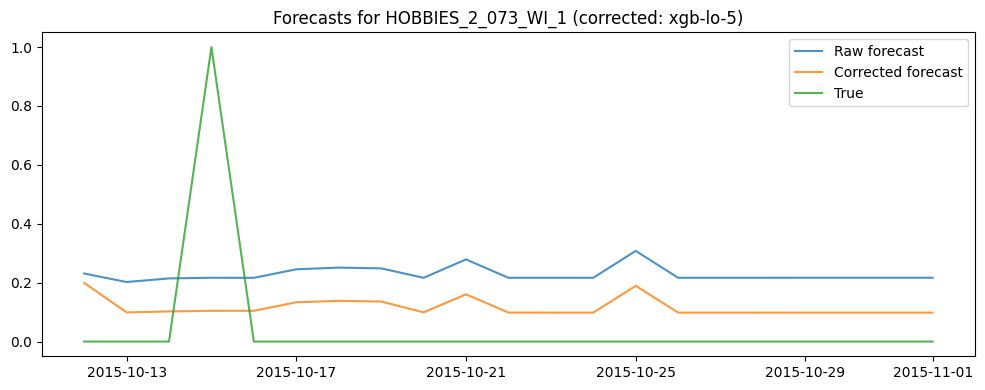

(np.float32(4.794902), np.float32(2.447807), np.float32(1.0))


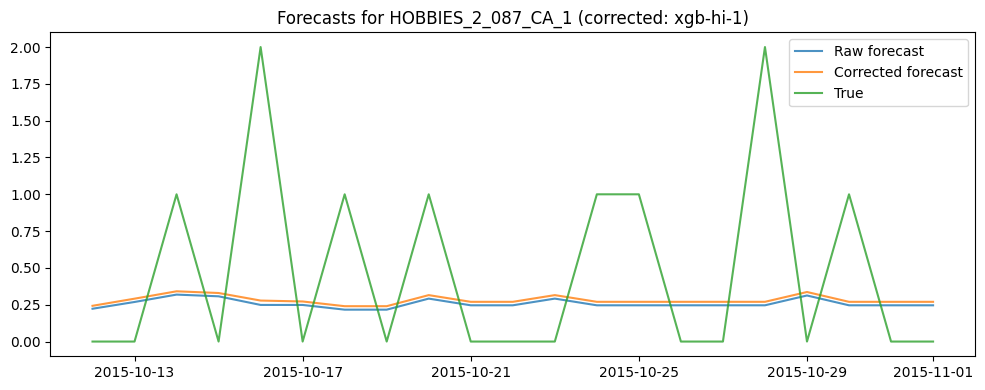

(np.float32(5.4058557), np.float32(5.901536), np.float32(10.0))


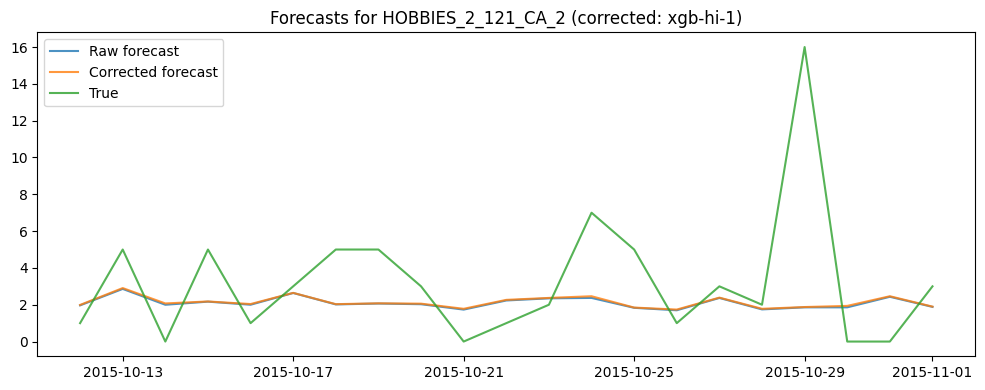

(np.float32(44.11093), np.float32(44.79344), np.float32(68.0))


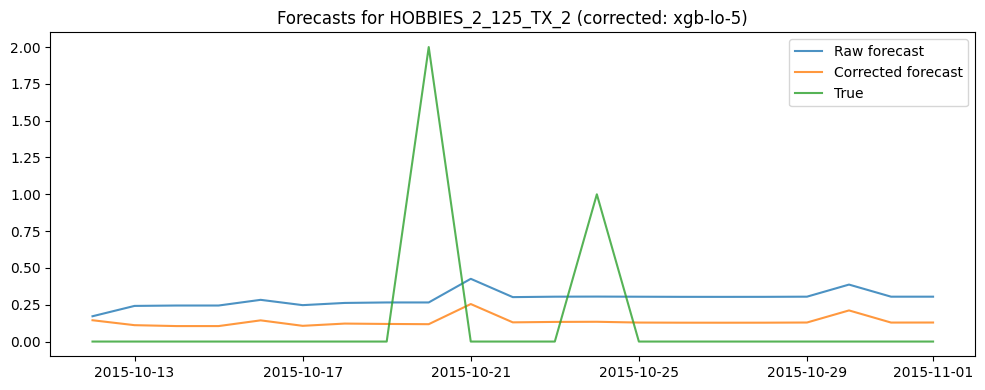

(np.float32(6.081644), np.float32(2.8414903), np.float32(3.0))


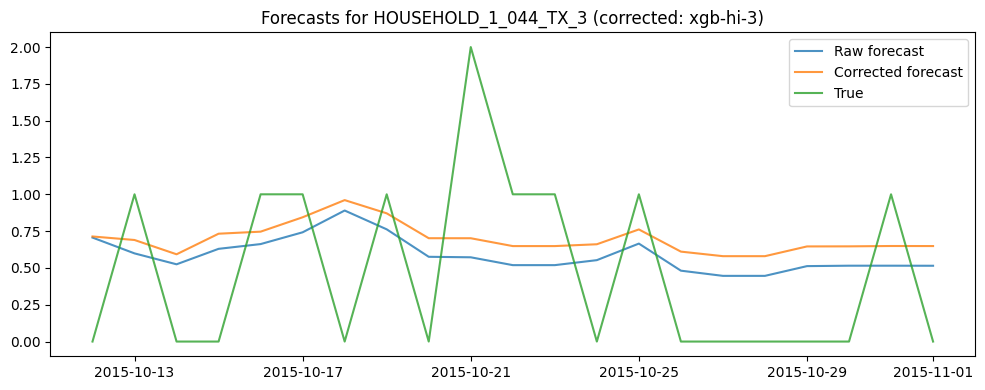

(np.float32(12.350046), np.float32(14.633021), np.float32(10.0))


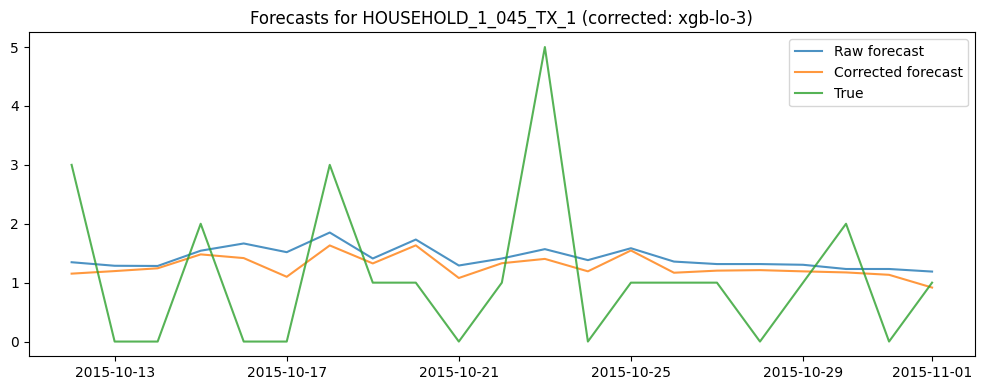

(np.float32(29.817432), np.float32(26.733019), np.float32(23.0))


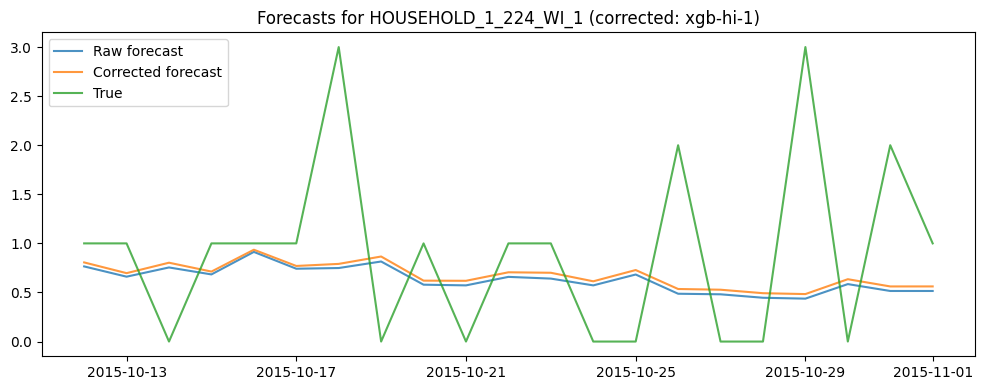

(np.float32(13.258777), np.float32(14.167836), np.float32(19.0))


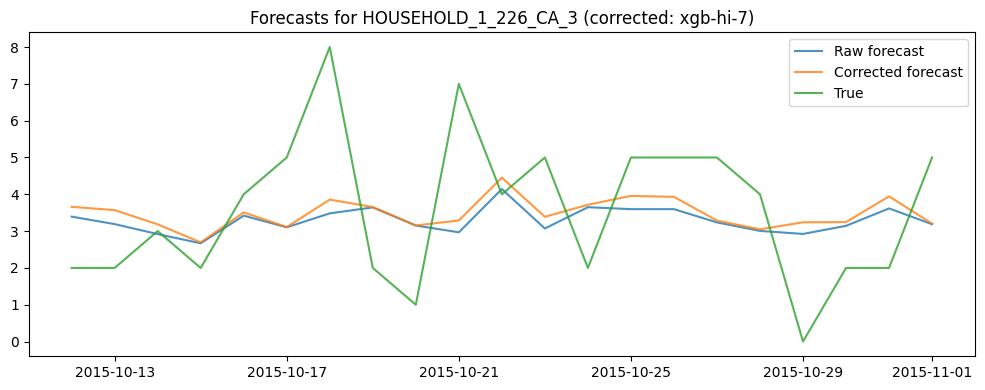

(np.float32(69.11266), np.float32(73.091034), np.float32(75.0))


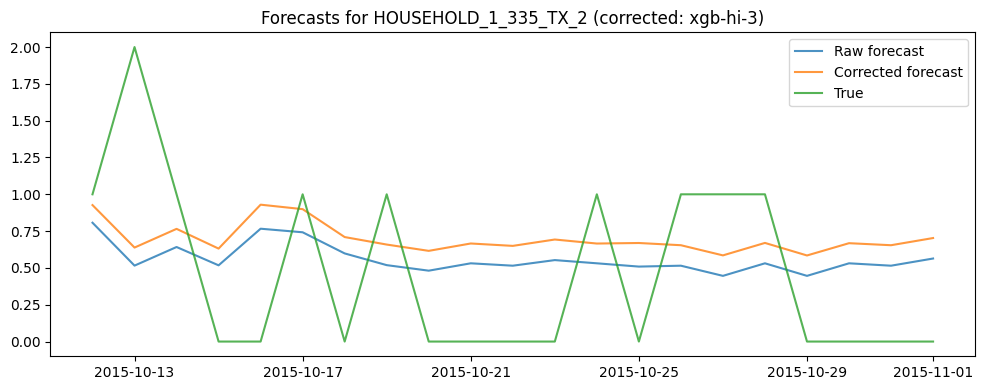

(np.float32(11.779201), np.float32(14.637609), np.float32(10.0))


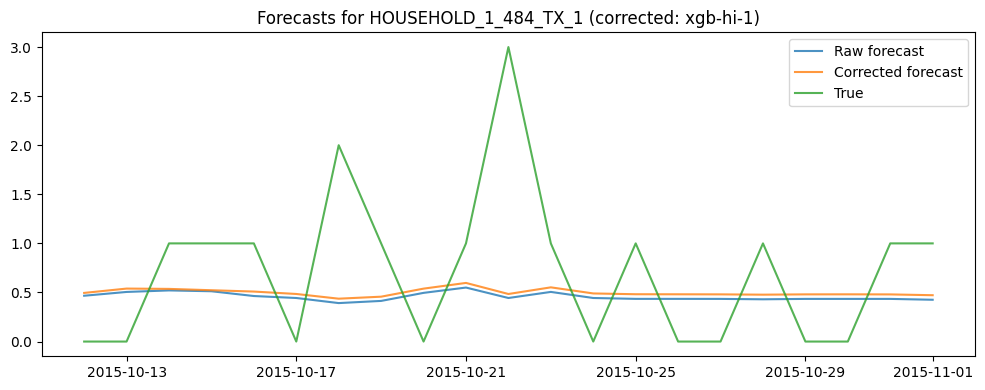

(np.float32(9.621513), np.float32(10.480759), np.float32(15.0))


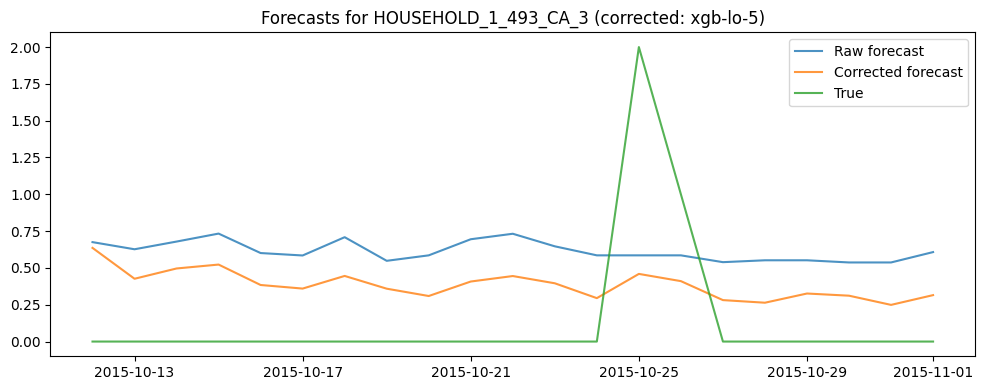

(np.float32(12.897211), np.float32(8.099586), np.float32(3.0))


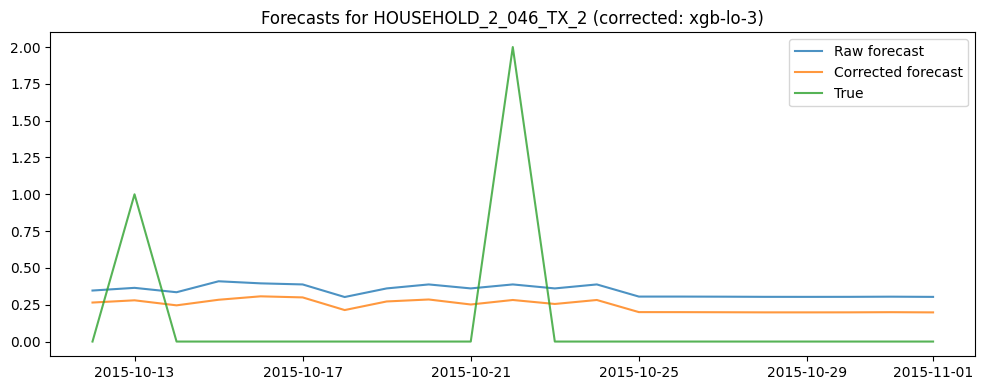

(np.float32(7.2219768), np.float32(5.116057), np.float32(3.0))


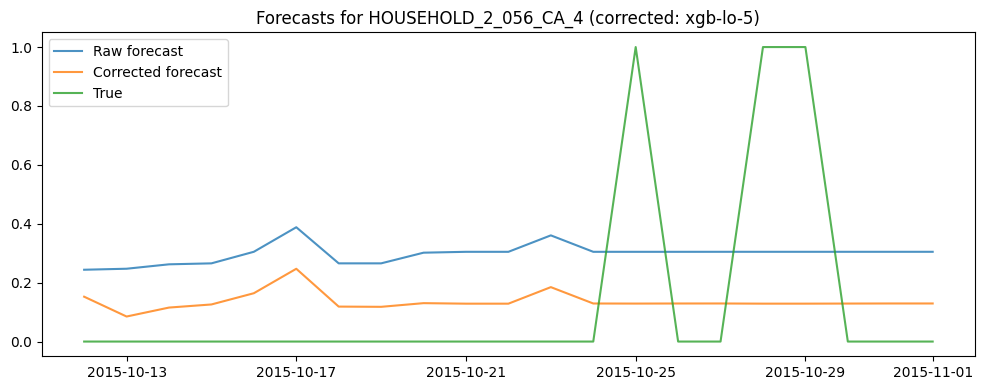

(np.float32(6.2577024), np.float32(2.8607287), np.float32(3.0))


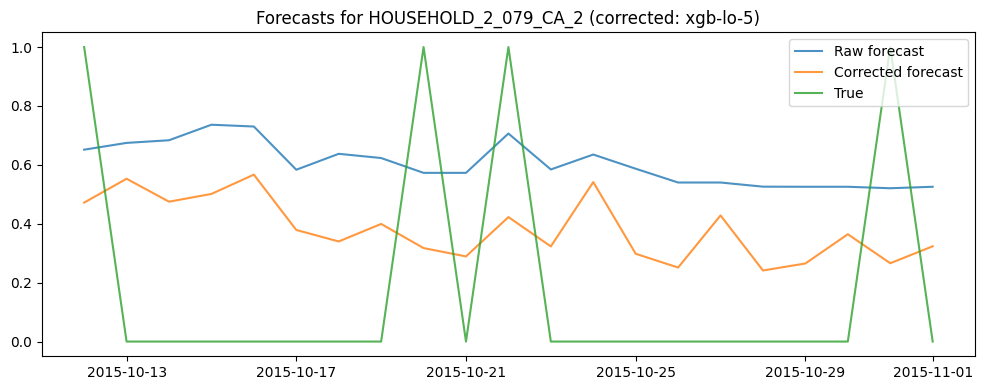

(np.float32(12.681906), np.float32(8.017569), np.float32(4.0))


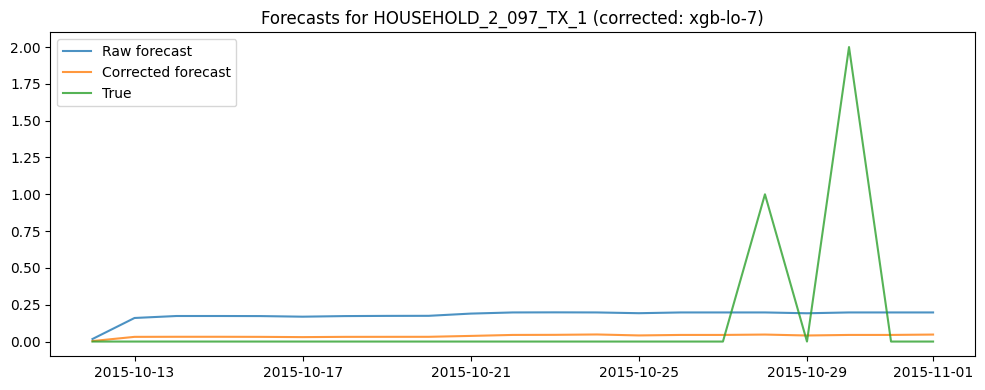

(np.float32(3.7425451), np.float32(0.7928285), np.float32(3.0))


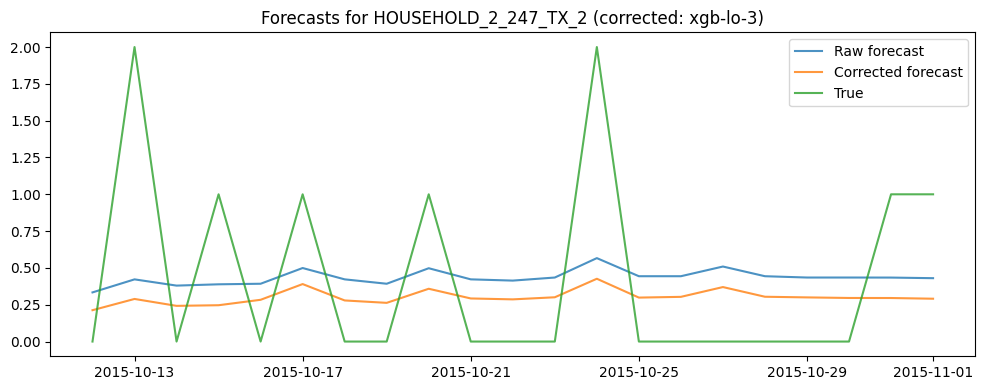

(np.float32(9.142712), np.float32(6.3313475), np.float32(9.0))


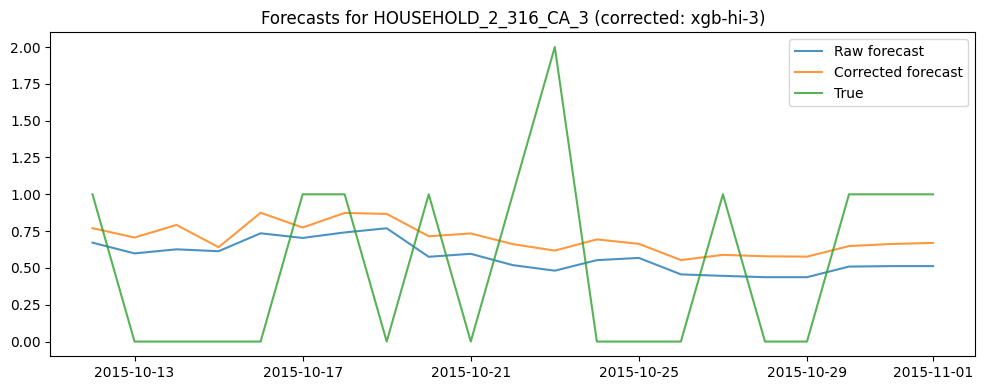

(np.float32(12.062605), np.float32(14.663513), np.float32(11.0))


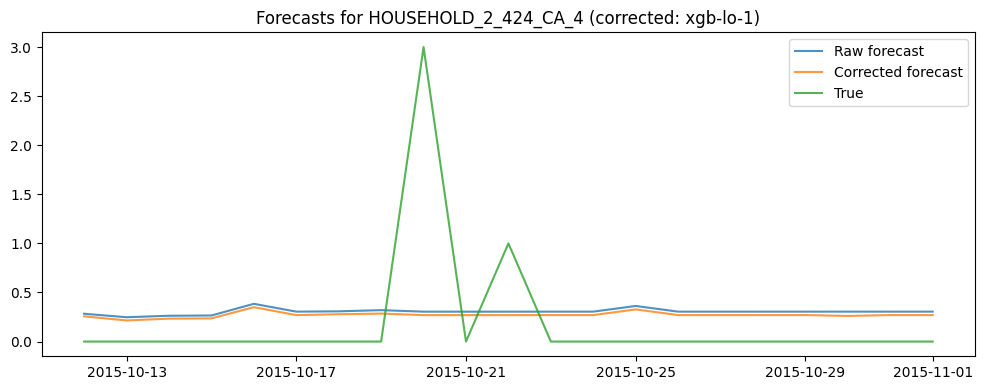

(np.float32(6.3954163), np.float32(5.6765175), np.float32(4.0))


In [86]:
import matplotlib.pyplot as plt

name = "xgb"
corr = auto_corr.percentile_correction_[name]
corr_ids = list(corr["id_to_col"].keys())

# raw predictions WITH the needed percentile columns
raw_preds = auto_corr.models_[name].predict(
    h=h,
    level=corr["levels"],  # make sure percentile cols exist
)

# corrected predictions (auto_corr.predict applies correction)
corr_preds = auto_corr.predict(h=h)

for uid in corr_ids[0:50]:
    raw_uid = raw_preds[raw_preds["unique_id"] == uid]
    corr_uid = corr_preds[corr_preds["unique_id"] == uid]
    test_uid = test_i[test_i["unique_id"] == uid]
    # valid_uid = valid[valid["unique_id"] == uid]

    #if raw_uid.empty or corr_uid.empty or valid_uid.empty:
    #    continue

    plt.figure(figsize=(10, 4))
    # plt.plot(valid_uid["ds"], valid_uid["y"], label="Actuals (valid.y)", color="black", alpha=0.8)
    plt.plot(raw_uid["ds"], raw_uid[name], label="Raw forecast", alpha=0.8)
    plt.plot(corr_uid["ds"], corr_uid[name], label="Corrected forecast", alpha=0.8)
    plt.plot(test_uid["ds"], test_uid['y'], label="True", alpha=0.8)
    plt.title(f"Forecasts for {uid} (corrected: {corr['id_to_col'][uid]})")
    plt.legend()
    plt.tight_layout()
    plt.show()
    print((raw_uid[name].sum(),
              corr_uid[name].sum(),
              test_uid['y'].sum()
              ))


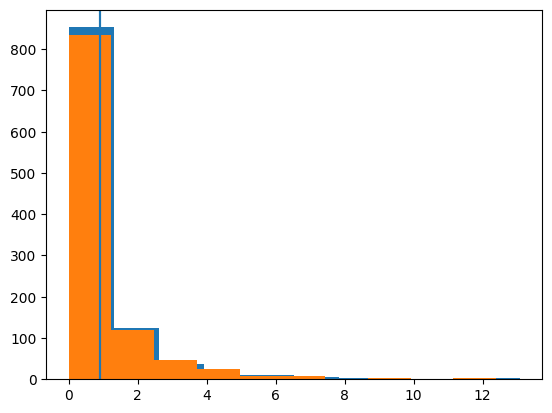

In [46]:
plt.hist(preds_all[preds_all.unique_id.isin(corr_ids)].res_base)
plt.axvline(preds_all[preds_all.unique_id.isin(corr_ids)].res_base.mean())
plt.hist(preds_all[preds_all.unique_id.isin(corr_ids)].res_best)
plt.axvline(preds_all[preds_all.unique_id.isin(corr_ids)].res_best.mean())